# Classificacion de imagenes: *CIFAR-10 dataset*

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

_**NOTA:** Durante el desarrollo de este trabajo investigué más ascerca de la redes neuronales, especificamente las convolucionales. Todo lo nuevo que lei y utilicé para el desarrollo del modelo traté de explicarlo previo a su utilizacion._

## Adquisición de los datos

Voy a utilizar el dataset `cifar10` de *keras*

In [2]:
(train_data, train_labels), (test_data, test_labels) = keras.datasets.cifar10.load_data()
train_labels = train_labels.reshape(-1)
test_labels = test_labels.reshape(-1)

## Inspección de los datos

In [3]:
print(f"Datos de entrenamiento: {len(train_data)}")
print(f"Datos de prueba: {len(test_data)}")
print(f"Forma de los datos: {train_data[0].shape}")

Datos de entrenamiento: 50000
Datos de prueba: 10000
Forma de los datos: (32, 32, 3)


- Este dataset esta compuesto por 60000 images de 32x32 pixeles y sus respectivos canales RGB

Las imagenes pueden clasificarse en 10 categorias diferentes:

In [4]:
labels = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

Muestro algunas con sus respectivas categorias:

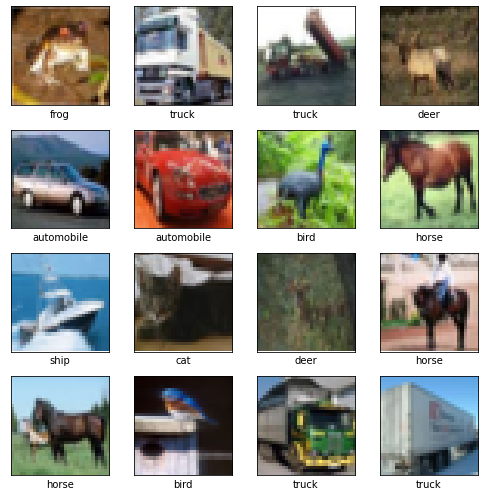

In [5]:
fig, axs = plt.subplots(4, 4, figsize=(7, 7))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_data[i])
    classification_index = train_labels[i]
    plt.xlabel(labels[classification_index])

plt.tight_layout()
plt.show()

## Preparación de los datos

Actualmente cada pixel está dado por 3 valores (RGB) entre 0 y 255. Voy a reescalarlos para utilizar una escala de 0 a 1 para cada canal de color.

Al mismo tiempo, convierto los datos a tensores:

In [6]:
scaled_train_data = tf.convert_to_tensor(train_data / 255)
scaled_test_data = tf.convert_to_tensor(test_data / 255)

## Modelado

Voy a definir un modelo secuencial de `keras`.

#### Capas `Conv2D`
Las capas `Conv2D` son muy utilizadas cuando se trabaja con imagenes. La cantidad de nodos de esta capa esta dada por la cantidad de filtros que se quieran obtener. 

Un filtro es una imagen nueva, resultado de "escanear" cada canal de la imagen de *input* utilizando una matriz o *kernel* que, utilizando los valores de los pixeles adyacentas a cada pixel, obtiene un nuevo valor para dicho pixel.
- Los filtros permiten identificar patrones dentro de una imagen, como por ejemplo, deteccion de bordes, figuras, etc

Podemos calcular la cantidad de pesos de esta capa como:\
`numero de filtros x dim_kernel_X x dim_kernel_Y x canales de entrada + numero de filtros`\
A estos pesos se le sumarian los *biases* iguales al `numero de filtros`.

El output de esta capa, entonces, resulta en `<numero de filtros>` imagenes. O, como me gusta pensarlo, la misma imagen descompuesta en `<numero de filtros>` canales nuevos.
- Bajo este punto de vista es facil ver como se podrian utilizar otras capas `Conv2D` en serie

#### Capas `MaxPooling2D`
De forma similar a `Conv2D`, este tipo de capas, escanean cada canal de la imagen input, agrupando varios pixeles en una matriz de dimensiones dadas. Luego obtienen el maximo de cada agrupacion y lo convierten en el representante de ese subconjunto de pixeles en la imagen de salida. De esta forma, estas capas logran reducir las dimensiones de la imagen *input*.

Estas capas no incorporan nuevos parametros para optimizar, ya que su unica funcion es la de transformar la imagen de entrada a otra de menores dimensiones.

#### Mi modelo
Considerando que la capa de entrada tendrá la forma: `(32, 32, 3)`
- imagen de 32x32 con 3 canales

Voy a utilizar 3 series de: `Conv2D` > `Conv2D` > `MaxPooling2D`, cada vez aumentando la cantidad de filtros de las capas `Conv2D` en una potencia de 2 empezando por `32`.
- Para las capas `Conv2D` voy a utilizar kernels de 3x3
- Para las capas `MaxPooling2D` voy a utilizar kernels de 2x2
    - Logrando capas que reducen el tamaño de las imagenes de entrada por 4

Luego, voy a utilizar una capa `Flatten` que, al igual que `MaxPooling2D`, no incorpora nuevos parametros a la red. Su función es la de "aplanar" o transformar la imagen *input* a su representacion como vector de una sola dimensión.

El resultado de esta capa me sirve para finalmente almientarlo a la capa de salida que voy a utilizar:

Una capa `Dense` de `10` neuronas completamente vinculadas a la capa anterior que representan las diferentes clasificaciones de nuestro problema. Esta capa utiliza la funcion de activacion "softmax" que obtiene resultados dentro del intervalo (0, 1) y logra que la suma de los mismos resulte 1 y, por lo tanto, cada resultado representará la "certeza" que tiene el modelo de que ese nodo representa la clasificacion correcta.

In [7]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=(32, 32, 3)))
model.add(keras.layers.Conv2D(32, 3, padding="same", activation="relu"))
model.add(keras.layers.MaxPooling2D(2, 2))

model.add(keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(keras.layers.Conv2D(64, 3, padding="same", activation="relu"))
model.add(keras.layers.MaxPooling2D(2, 2))

model.add(keras.layers.Conv2D(128, 3, padding="same", activation="relu"))
model.add(keras.layers.Conv2D(128, 3, padding="same", activation="relu"))
model.add(keras.layers.MaxPooling2D(2, 2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))  # Capa de salida

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         7

In [8]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [9]:
epochs = 8
validation_split = 0.2
batch_size = round(len(scaled_train_data) * (1 - validation_split) / 500)
print(f"Epochs: {epochs}")
print(f"Batch size: {batch_size}\n")
history = model.fit(scaled_train_data, train_labels, validation_split=validation_split, batch_size=batch_size, epochs=epochs, verbose=1)

Epochs: 8
Batch size: 80

Epoch 1/8
500/500 [==============================] - 93s 184ms/step - loss: 1.8208 - accuracy: 0.3268 - val_loss: 1.1772 - val_accuracy: 0.5778
Epoch 2/8
500/500 [==============================] - 80s 160ms/step - loss: 1.1311 - accuracy: 0.5987 - val_loss: 0.9303 - val_accuracy: 0.6742
Epoch 3/8
500/500 [==============================] - 78s 156ms/step - loss: 0.8828 - accuracy: 0.6908 - val_loss: 0.7954 - val_accuracy: 0.7255
Epoch 4/8
500/500 [==============================] - 78s 156ms/step - loss: 0.7267 - accuracy: 0.7460 - val_loss: 0.7525 - val_accuracy: 0.7413
Epoch 5/8
500/500 [==============================] - 81s 162ms/step - loss: 0.6090 - accuracy: 0.7887 - val_loss: 0.6838 - val_accuracy: 0.7665
Epoch 6/8
500/500 [==============================] - 81s 162ms/step - loss: 0.5057 - accuracy: 0.8258 - val_loss: 0.6946 - val_accuracy: 0.7702
Epoch 7/8
500/500 [==============================] - 79s 159ms/step - loss: 0.4320 - accuracy: 0.8506 - val_lo

## Evaluacion

Un a vez entrenado el modelo, lo pruebo contra el conjunto de prueba:

In [10]:
results = model.evaluate(scaled_test_data, test_labels, verbose=0)
print(f"Precisión: {round(results[1] * 100, 2)}%")

Precisión: 76.42%


Visualizo el proceso de entrenamiento:

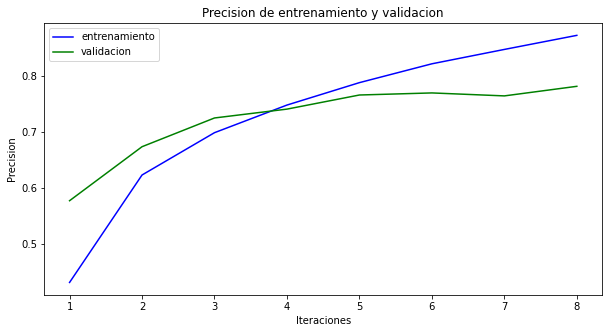

In [11]:
import matplotlib.pyplot as plt

history_dict = history.history

n_epochs = len(history_dict["accuracy"])
epochs = np.arange(1, n_epochs+1)

plt.figure(figsize=(10, 5))

# Graficamos las metricas del conjunto de entrenamiento
plt.plot(epochs, history_dict["accuracy"], "b", label="entrenamiento")

# Graficamos las metricas del conjunto de validacion
plt.plot(epochs, history_dict["val_accuracy"], "g", label="validacion")

plt.title("Precision de entrenamiento y validacion")
plt.xlabel("Iteraciones")
plt.ylabel("Precision")
plt.legend()
plt.show()

- Esta claro que continuar el entrenamiento durante mas *epochs* no hubiera mejorado al modelo sino que hubiera producido *overfitting*
- Y la precision en el conjunto de validación no hubiera crecido más

In [12]:
predictions = model.predict(scaled_test_data)

#### Analisis de errores:

In [13]:
label_errors = { label: { other_label: 0 for other_label in labels } for label in labels }

for i, img_prediction in enumerate(predictions):
    best_index = np.argmax(img_prediction)  # Indice del maximo valo en el vector
    classification = labels[best_index]
    real_classification = labels[test_labels[i]]
    
    if real_classification != classification:
        label_errors[real_classification][classification] += 1

Visualizo la cantidad de errores:

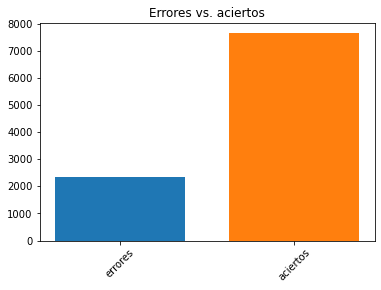

In [14]:
width = 1.5
xticks = np.linspace(0, 2, 2)

error_count = sum([sum(errors.values()) for errors in label_errors.values()])
plt.bar(xticks[0], error_count, width)
plt.bar(xticks[1], len(predictions) - error_count, width)
plt.title("Errores vs. aciertos")
plt.xticks(xticks, ["errores", "aciertos"], rotation=45)
plt.show()

Visualizo la cantidad de errores que hubo para cada categoria:

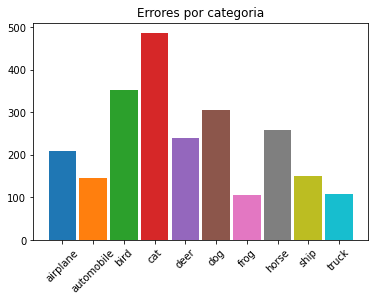

In [15]:
width = 1
xticks = np.linspace(0, 10, len(labels))
for i, errors in enumerate(label_errors.values()):
    class_error_count = sum(errors.values())
    plt.bar(xticks[i], class_error_count, width)

plt.title("Errores por categoria")
plt.xticks(xticks, labels, rotation=45)
plt.show()

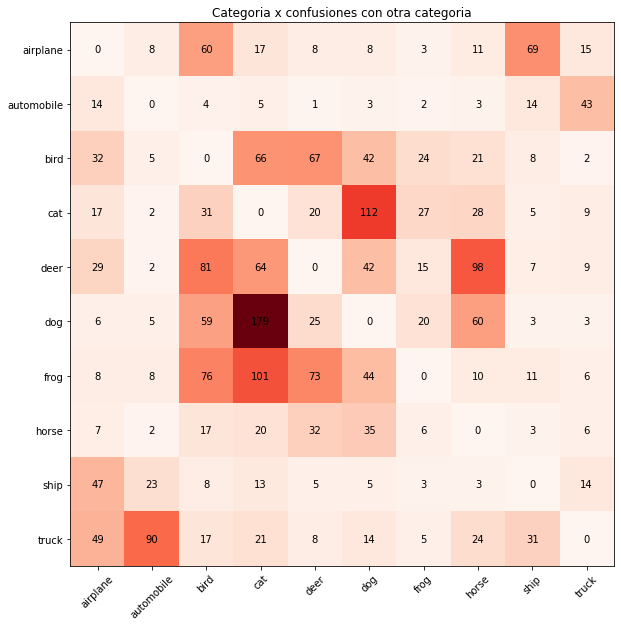

In [19]:
plt.figure(figsize=(10, 10))

error_matrix = np.transpose(np.array([[*errors.values()] for errors in label_errors.values()]))
plot_size = len(label_errors)

for i in range(plot_size):
    for j in range(plot_size):
        plt.text(j, i, error_matrix[i, j], ha="center", va="center")

ticks = np.arange(plot_size)
plt.xticks(ticks, labels, rotation=45)
plt.yticks(ticks, labels)
plt.title("Categoria x confusiones con otra categoria")
plt.imshow(error_matrix, cmap=plt.get_cmap("Reds"))
plt.show()

Algunos ejemplos:

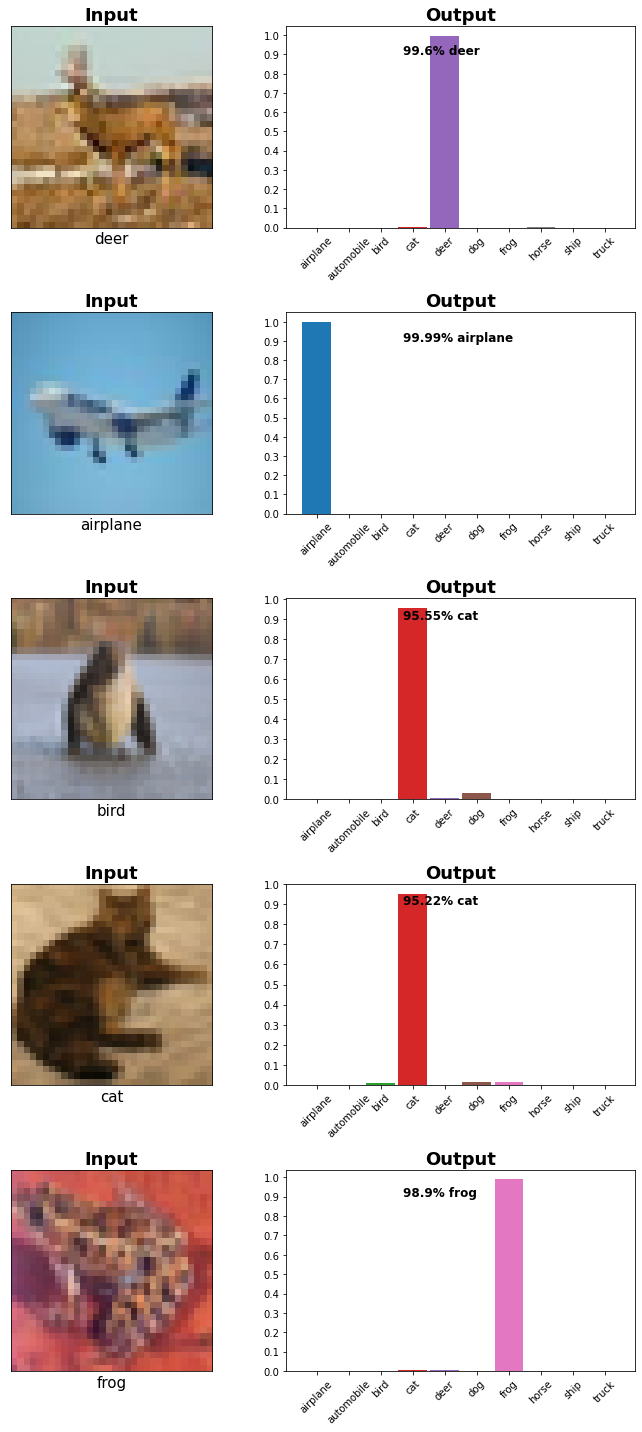

In [17]:
EXAMPLE_AMOUNT = 5
np.random.seed(23)
IMGS = np.random.randint(0, len(predictions), size=EXAMPLE_AMOUNT)


fig, axs = plt.subplots(EXAMPLE_AMOUNT, 2, figsize=(10, 4 * EXAMPLE_AMOUNT))

for n, IMG_INDEX in enumerate(IMGS):
    axs[n, 0].set_title("Input", fontweight="bold", fontsize=18)
    axs[n, 0].set_xticks([])
    axs[n, 0].set_yticks([])
    real_classification = labels[test_labels[IMG_INDEX]]
    axs[n, 0].set_xlabel(real_classification, fontsize=15)
    axs[n, 0].imshow(scaled_test_data[IMG_INDEX])

    img_prediction = predictions[IMG_INDEX]

    width = 1
    xticks = np.linspace(0, 10, len(labels))
    for c in range(10):
        axs[n, 1].bar(xticks[c], img_prediction[c], width)

    axs[n, 1].set_xticks(xticks)
    axs[n, 1].set_xticklabels(labels, rotation=45)
    axs[n, 1].set_yticks(np.arange(0, 1.1, step=0.1))
    axs[n, 1].set_title("Output", fontweight="bold", fontsize=18)

    best_index = np.argmax(img_prediction)  # Indice del maximo valo en el vector
    classification = labels[best_index]
    certainty = round(np.max(img_prediction) * 100, 2)
    axs[n, 1].text(3, 0.9, f"{certainty}% {classification}", fontsize=12, fontweight="bold")
    
plt.tight_layout()
plt.show()

<br>

## Conclusiones:

Del analisis anterior observo que:

El modelo responde bien a las imagenes de aviones, ranas, camiones y barcos.

Presenta leves dificultadas con las imagenes de:
- Autos, ya que las confunde mayormente con las de camiones
- Caballos, ya que los confunde generalmente con ciervos y perrors

Las imagenes con las que tiene mayores dificultades son:
- *Pajaros:* se le dificulta identificar pajaros en general, no los confunde con otra clase particular
- *Gatos:* los confunde bastante con otros animales en general, pero principalmente los confunde mucho con los perros y otro tanto con ranas
- *Ciervos:* no los confunde tanto, pero presenta dificultades para diferenciarlos particularmente de los pajaros y ranas sorprendentemente
- *Perros:* los confunde particularmente con los gatos

Considero que un 75% de precisión es un buen resultado en este contexto. Para lograr superarlo necesitaría investigar un poco más ascerca de qué otros tipos de capas provee `keras` que pudieran ayudar a mejorar el modelo.